### Requirements

## Load Librabries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from simpletransformers.ner import NERModel,NERArgs
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from tabulate import tabulate
nltk.download('stopwords')
from collections import defaultdict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Data

In [35]:
df = pd.read_excel('data_frame_soft_skills.xlsx').drop(['Unnamed: 0'], axis=1)

In [36]:
df.head(5000)

,sentence,word,tags
0,sentence 1,Forte,O
1,sentence 1,capacité,B-pensee
2,sentence 1,d'ANALYSE,I-pensee
3,sentence 2,Sens,B-ethique_pro
4,sentence 2,de,I-ethique_pro
...,...,...,...
4995,sentence 511,avoir,O
4996,sentence 511,une,O
4997,sentence 511,conversation,B-communication
4998,sentence 511,fluide,I-communication


In [37]:
print("Taille de data set : ", df.shape, "- Nombre de phrases :", df['sentence'].iloc[-1].split()[-1])

Taille de data set :  (19783, 3) - Nombre de phrases : 1905


## 1. Pre-processing

<Axes: >

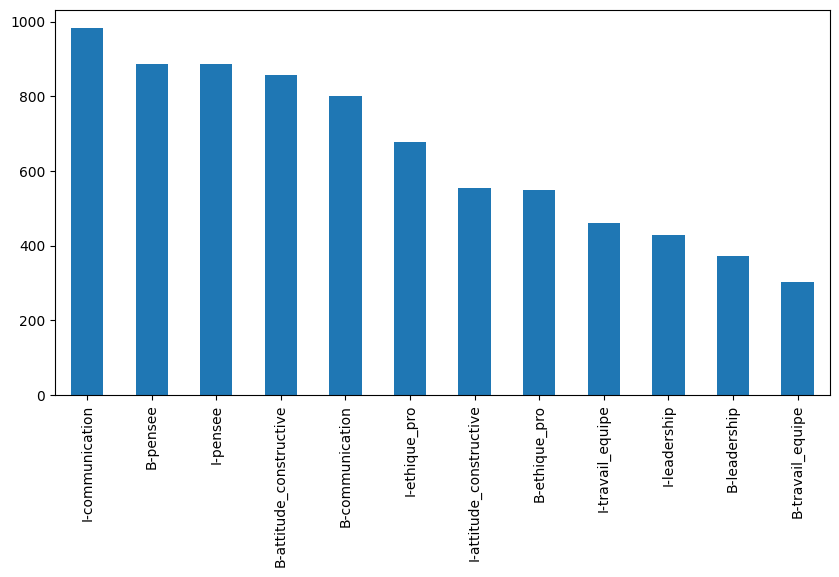

In [38]:
df[df["tags"]!="O"]["tags"].value_counts().plot(kind="bar", figsize=(10,5))

In [39]:
sentence_lengths = len(df['sentence'].value_counts())

MEDIANE :  9.0


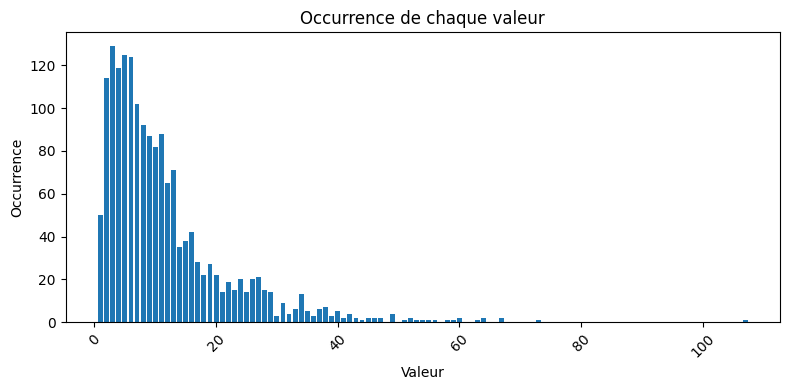

{107: 1, 73: 1, 67: 2, 64: 2, 63: 1, 60: 2, 59: 1, 58: 1, 56: 1, 55: 1, 54: 1, 53: 1, 52: 2, 51: 1, 49: 4, 47: 2, 46: 2, 45: 2, 44: 1, 43: 2, 42: 4, 41: 2, 40: 5, 39: 3, 38: 7, 37: 6, 36: 3, 35: 5, 34: 13, 33: 6, 32: 4, 31: 9, 30: 3, 29: 14, 28: 15, 27: 21, 26: 20, 25: 14, 24: 20, 23: 15, 22: 19, 21: 14, 20: 22, 19: 27, 18: 22, 17: 28, 16: 42, 15: 38, 14: 35, 13: 71, 12: 65, 11: 88, 10: 82, 9: 87, 8: 92, 7: 102, 6: 124, 5: 125, 4: 119, 3: 129, 2: 114, 1: 50}


In [41]:
sentence_counts = df['sentence'].value_counts()
print("MEDIANE : ", np.median(sentence_counts))

size_sentence = []
for index, value in df['sentence'].value_counts().items():
    size_sentence.append(value)

value_counts = {}
for value in size_sentence:
    value_counts[value] = value_counts.get(value, 0) + 1

# Créer un diagramme en barres (bar plot)
plt.figure(figsize=(8, 4))
plt.bar(value_counts.keys(), value_counts.values())
plt.title("Occurrence de chaque valeur")
plt.xlabel("Valeur")
plt.ylabel("Occurrence")
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le diagramme en barres
plt.show()

print(value_counts)

In [42]:
## Rename columns
df.rename(columns={"sentence": "sentence_id", "word": "words", "tags": "labels"}, inplace=True)
df.head()

,sentence_id,words,labels
0,sentence 1,Forte,O
1,sentence 1,capacité,B-pensee
2,sentence 1,d'ANALYSE,I-pensee
3,sentence 2,Sens,B-ethique_pro
4,sentence 2,de,I-ethique_pro


In [43]:
print(df.shape)
df = df.dropna()
print(df.shape)

(19783, 3)
(19636, 3)


## 2. Create Model

### 2.1 Define params

In [44]:
# Define params of the model
args = NERArgs()
args.num_train_epochs = 50
args.learning_rate = 1e-4
args.overwrite_output_dir =True
args.train_batch_size = 8
args.eval_batch_size = 8
args.save_steps = -1
args.save_model_every_epoch = False

In [45]:
label = df["labels"].unique().tolist()
label

['O',
 'B-pensee',
 'I-pensee',
 'B-ethique_pro',
 'I-ethique_pro',
 'B-attitude_constructive',
 'B-communication',
 'I-communication',
 'I-attitude_constructive',
 'B-travail_equipe',
 'I-travail_equipe',
 'B-leadership',
 'I-leadership']

In [46]:
model = NERModel('camembert', 'camembert-base',labels=label,args=args,use_cuda=True)

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_model.py:433: UserWarning: use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.
  warnings.warn(


In [47]:
df

,sentence_id,words,labels
0,sentence 1,Forte,O
1,sentence 1,capacité,B-pensee
2,sentence 1,d'ANALYSE,I-pensee
3,sentence 2,Sens,B-ethique_pro
4,sentence 2,de,I-ethique_pro
...,...,...,...
19778,sentence 1905,prendre,B-leadership
19779,sentence 1905,des,I-leadership
19780,sentence 1905,décisions,I-leadership
19781,sentence 1905,risques,O


### 2.2 Train model

In [48]:
size_train = df['sentence_id'].nunique()*0.80
size_eval = df['sentence_id'].nunique()*0.20

In [49]:
# Split dataframe
df['sentence_id'] = df['sentence_id'].str.replace('sentence ','')
df['sentence_id'] = df['sentence_id'].astype(int)

In [50]:
df_train = df[df['sentence_id'] <= round(size_train)]
df_temp = df[df['sentence_id'] > round(size_train)]

df_validation = df_temp[df_temp['sentence_id'] <= round(size_train+size_eval/2)]
df_test = df[df['sentence_id'] > round(size_train+size_eval/2)]

In [51]:
print(df.shape, df_train.shape, df_validation.shape, df_test.shape)

(19636, 3) (12961, 3) (1852, 3) (4823, 3)


In [52]:
df_test

,sentence_id,words,labels
14911,1545,Vous,O
14912,1545,avez,O
14913,1545,un,O
14914,1545,minimum,O
14915,1545,d’expérience,O
...,...,...,...
19778,1905,prendre,B-leadership
19779,1905,des,I-leadership
19780,1905,décisions,I-leadership
19781,1905,risques,O


In [53]:
model.train_model(df_train,eval_data=df_validation,acc=accuracy_score)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/1207 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Running Epoch 0 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 2 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 3 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 4 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 5 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 6 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 7 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 8 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 9 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 10 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 11 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 12 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 13 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 14 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 15 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 16 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 17 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 18 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 19 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 20 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 21 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 22 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 23 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 24 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 25 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 26 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 27 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 28 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 29 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 30 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 31 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 32 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 33 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 34 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 35 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 36 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 37 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 38 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 39 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 40 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 41 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 42 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 43 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 44 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 45 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 46 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 47 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 48 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

Running Epoch 49 of 50:   0%|          | 0/151 [00:00<?, ?it/s]

(7550, 0.15118268470567056)

In [54]:
result_evaluation, model_outputs_, preds_list_ = model.eval_model(df_test)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/43 [00:00<?, ?it/s]

###### 2.3 Compute metrics

In [55]:
result_evaluation

{'eval_loss': 1.2940622076045636,
 'precision': 0.7007042253521126,
 'recall': 0.7201447527141134,
 'f1_score': 0.7102914931588339}

In [56]:
def concat_labels_by_sentence_id(df):
    sentence_ids = df['sentence_id'].unique()
    concatenated_labels = []

    for sentence_id in sentence_ids:
        labels = df[df['sentence_id'] == sentence_id]['labels'].tolist()
        concatenated_labels.append(labels)

    return concatenated_labels

In [57]:
labeled_test = concat_labels_by_sentence_id(df_test)

In [58]:
preds_list_2 = [item for sublist in preds_list_ for item in sublist]

In [59]:
labeled_test_2 = [item for sublist in labeled_test for item in sublist]

In [60]:
from collections import defaultdict

# Init dict to save true predictions by labels
correct_predictions_by_label = defaultdict(int)
total_predictions_by_label = defaultdict(int)
true_positives_by_label = defaultdict(int)
false_positives_by_label = defaultdict(int)
false_negatives_by_label = defaultdict(int)

# Compute true prediction, true postif and false negatif by label
for p, t in zip(preds_list_2, labeled_test_2):
    if p == t:
        correct_predictions_by_label[t] += 1
        true_positives_by_label[t] += 1
    else:
        false_positives_by_label[p] += 1
        false_negatives_by_label[t] += 1
    total_predictions_by_label[t] += 1

# Compute presicion, recall and F1-socre by label
precision_by_label = {}
recall_by_label = {}
f1_score_by_label = {}

for label in total_predictions_by_label.keys():
    precision = correct_predictions_by_label[label] / (correct_predictions_by_label[label] + false_positives_by_label[label])
    recall = correct_predictions_by_label[label] / (correct_predictions_by_label[label] + false_negatives_by_label[label])
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    precision_by_label[label] = precision
    recall_by_label[label] = recall
    f1_score_by_label[label] = f1_score

# Print metrics
metrics_data = []
for label, precision in precision_by_label.items():
    recall = recall_by_label[label]
    f1_score = f1_score_by_label[label]

    #print(f"Label: {label}")
    #print(f"Précision: {precision:.4f}")
    #print(f"Rappel: {recall:.4f}")
    #print(f"F1-score: {f1_score:.4f}")
    #print()

    metrics_data.append([label, precision, recall, f1_score])

headers = ["Label", "Precision", "Recall", "F1-score"]
table = tabulate(metrics_data, headers=headers, tablefmt="fancy_grid", floatfmt=".2f")
print(table)

╒═════════════════════════╤═════════════╤══════════╤════════════╕
│ Label                   │   Precision │   Recall │   F1-score │
╞═════════════════════════╪═════════════╪══════════╪════════════╡
│ O                       │        0.92 │     0.94 │       0.93 │
├─────────────────────────┼─────────────┼──────────┼────────────┤
│ B-ethique_pro           │        0.80 │     0.77 │       0.78 │
├─────────────────────────┼─────────────┼──────────┼────────────┤
│ I-ethique_pro           │        0.83 │     0.70 │       0.76 │
├─────────────────────────┼─────────────┼──────────┼────────────┤
│ B-pensee                │        0.76 │     0.76 │       0.76 │
├─────────────────────────┼─────────────┼──────────┼────────────┤
│ B-communication         │        0.63 │     0.65 │       0.64 │
├─────────────────────────┼─────────────┼──────────┼────────────┤
│ I-communication         │        0.68 │     0.72 │       0.70 │
├─────────────────────────┼─────────────┼──────────┼────────────┤
│ I-pensee